In [1]:
## Imports 

%matplotlib inline
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
plt.rc('figure', figsize=(6, 5.5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')
import tensorflow as tf
from tensorflow import keras
import pandas as pd


# 1. Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $\mathbb{E}\left[Y|X\right]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$\mathbb{E}\left[Y|X\right]=f^{\ast}(X)\quad\text{and}\quad\mathbb{E}\left[\left|Y-f^{\ast}(X)\right|^2\right]\leq\mathbb{E}\left[\left|Y-f(X)\right|^2\right]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $\mathbb{E}\left[\left.Y\right|X\right] = \mathbb{E}\left[\left.g(X)+\varepsilon\right|X\right] = g(X)+\mathbb{E}\left[\left.\varepsilon\right|X\right] = g(X)$.

---

$ \text{Plotting a random sample of the joint distribution and the theoretical conditional expectation of Y wrt X.} $

Text(0, 0.5, 'Y')

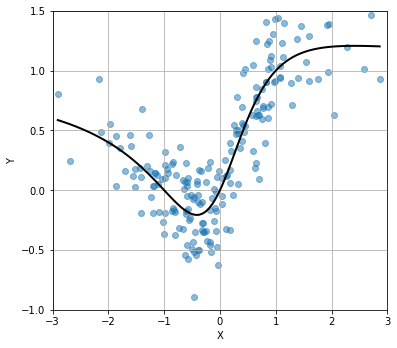

In [2]:
def g(x):
    return x*(1+x)/(1+x**2)

n = 200
sigma = 0.25
np.random.seed(1000)
X = np.random.randn(n)
Y = g(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)
ax.plot(x, g(x), 'k', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Parametric regression

The conditional expection $\mathbb{E}\left[\left.Y\right|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$\mathbb{E}\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where 

$$\mathbb{E}\left[\left(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X)\right)^2\right] = \min_{\beta_1,\ldots,\beta_n}\mathbb{E}\left[\left(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X)\right)^2\right]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\beta\|A\beta-y\|_2$, where

$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> is used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

In general, increasing the number of basis functions in the regression gives us more flexibility to better fit the data. However, having too many parameters in the model oftentimes leads to overfitting, which usually has poor predictive performance and is over-sensitive to small noise in the data. To observe the overftting phenomenon, in polynomial fit, we use different degrees of the polynomials; in piecewise-linear regression, we use different number of knots.

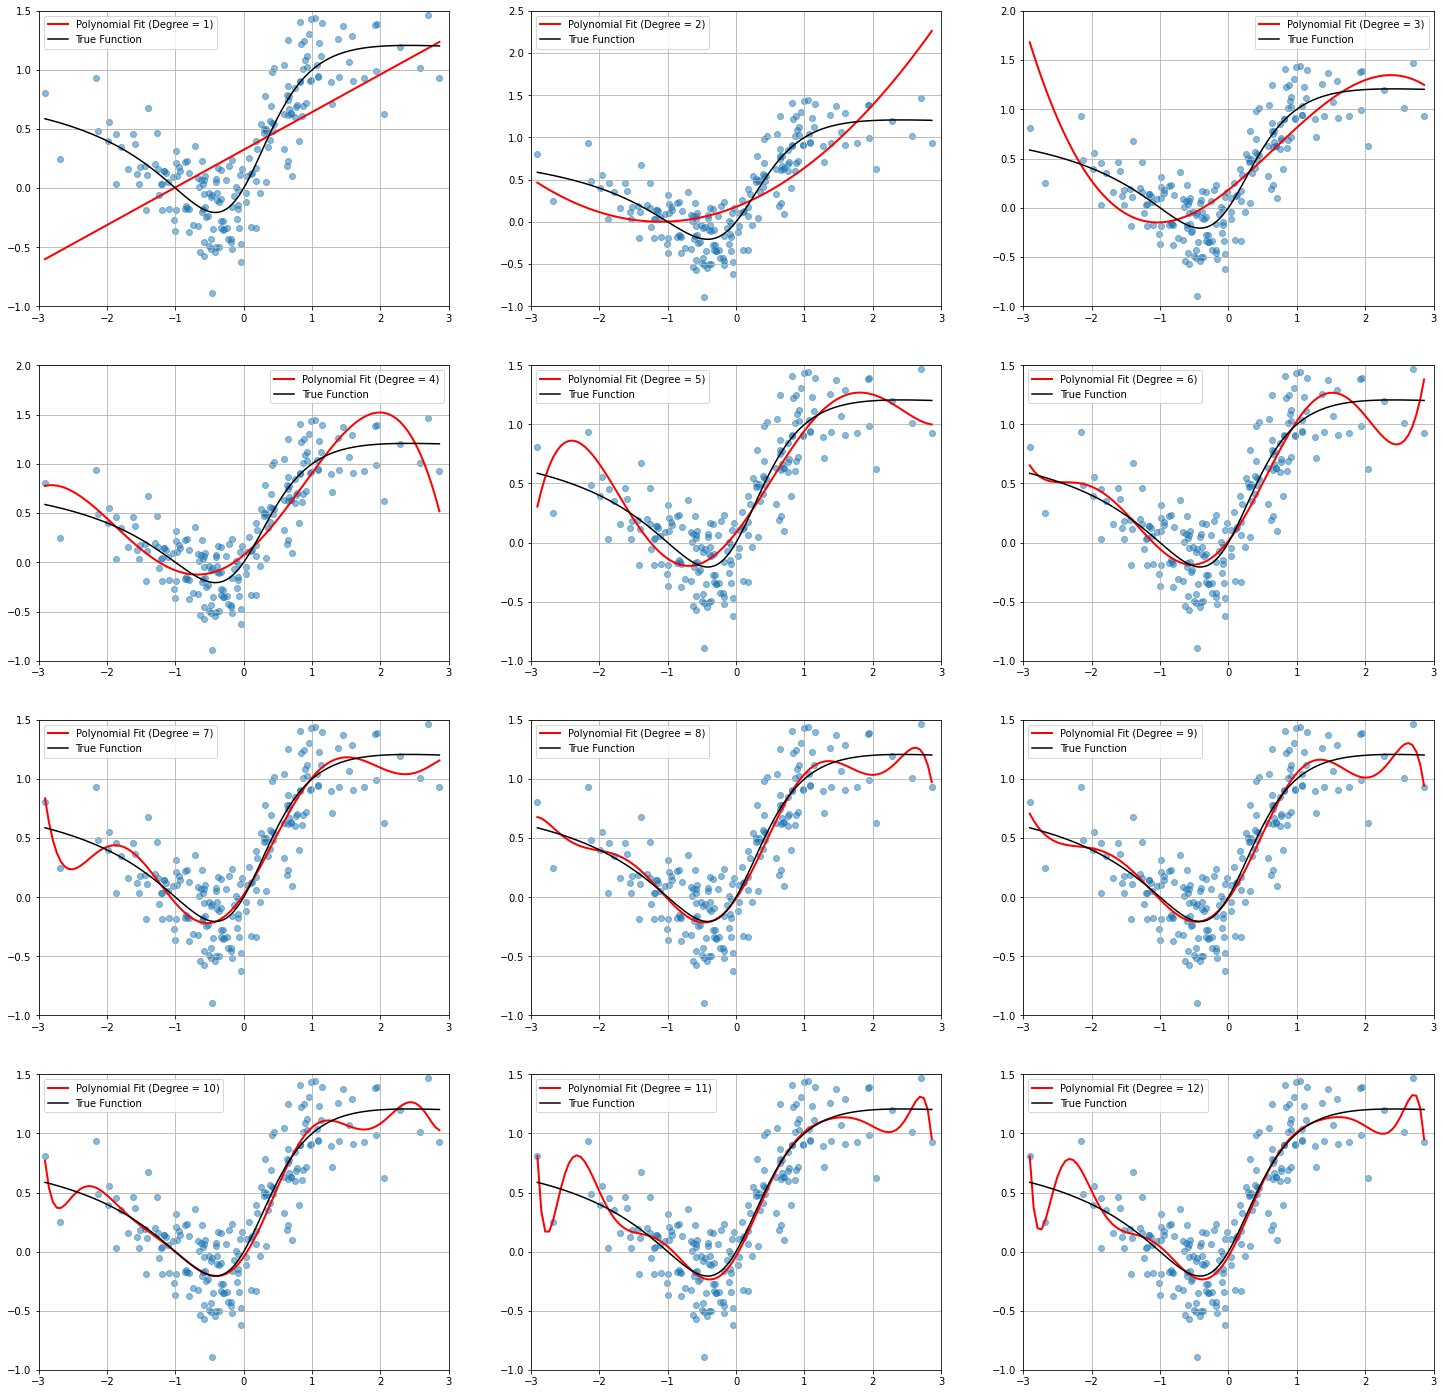

In [3]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
fig, ax = plt.subplots(4,3,figsize=(25,25))
for i in range(12) :
    p = np.polyfit(X, Y, deg=i+1)
    ax[i//3][i%3].scatter(X, Y, alpha=0.5)
    ax[i//3][i%3].plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit (Degree = ' + str(i+1) + ')' )
    ax[i//3][i%3].plot(x, g(x), 'k', label='True Function')
    ax[i//3][i%3].legend(loc=0)

##### Comments :
We see that the curve is not linear and is able to fit well if we include higher polynomials.
We observe good fit for degree 3-5. After that there is signnficant overfitting especially at the end points. Before that we see that the curve is not able to fit that well. 

---

### Piecewise Linear Regression

In [4]:
def pwlin_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    fs = [lambda x: np.ones_like(x, dtype=np.float64), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))]) ## lambda fn with 1 arg and 1kwarg
    return fs

def pwlin_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlin_basis(xknots)
    A = np.column_stack([f(xdata) for f in fs])
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

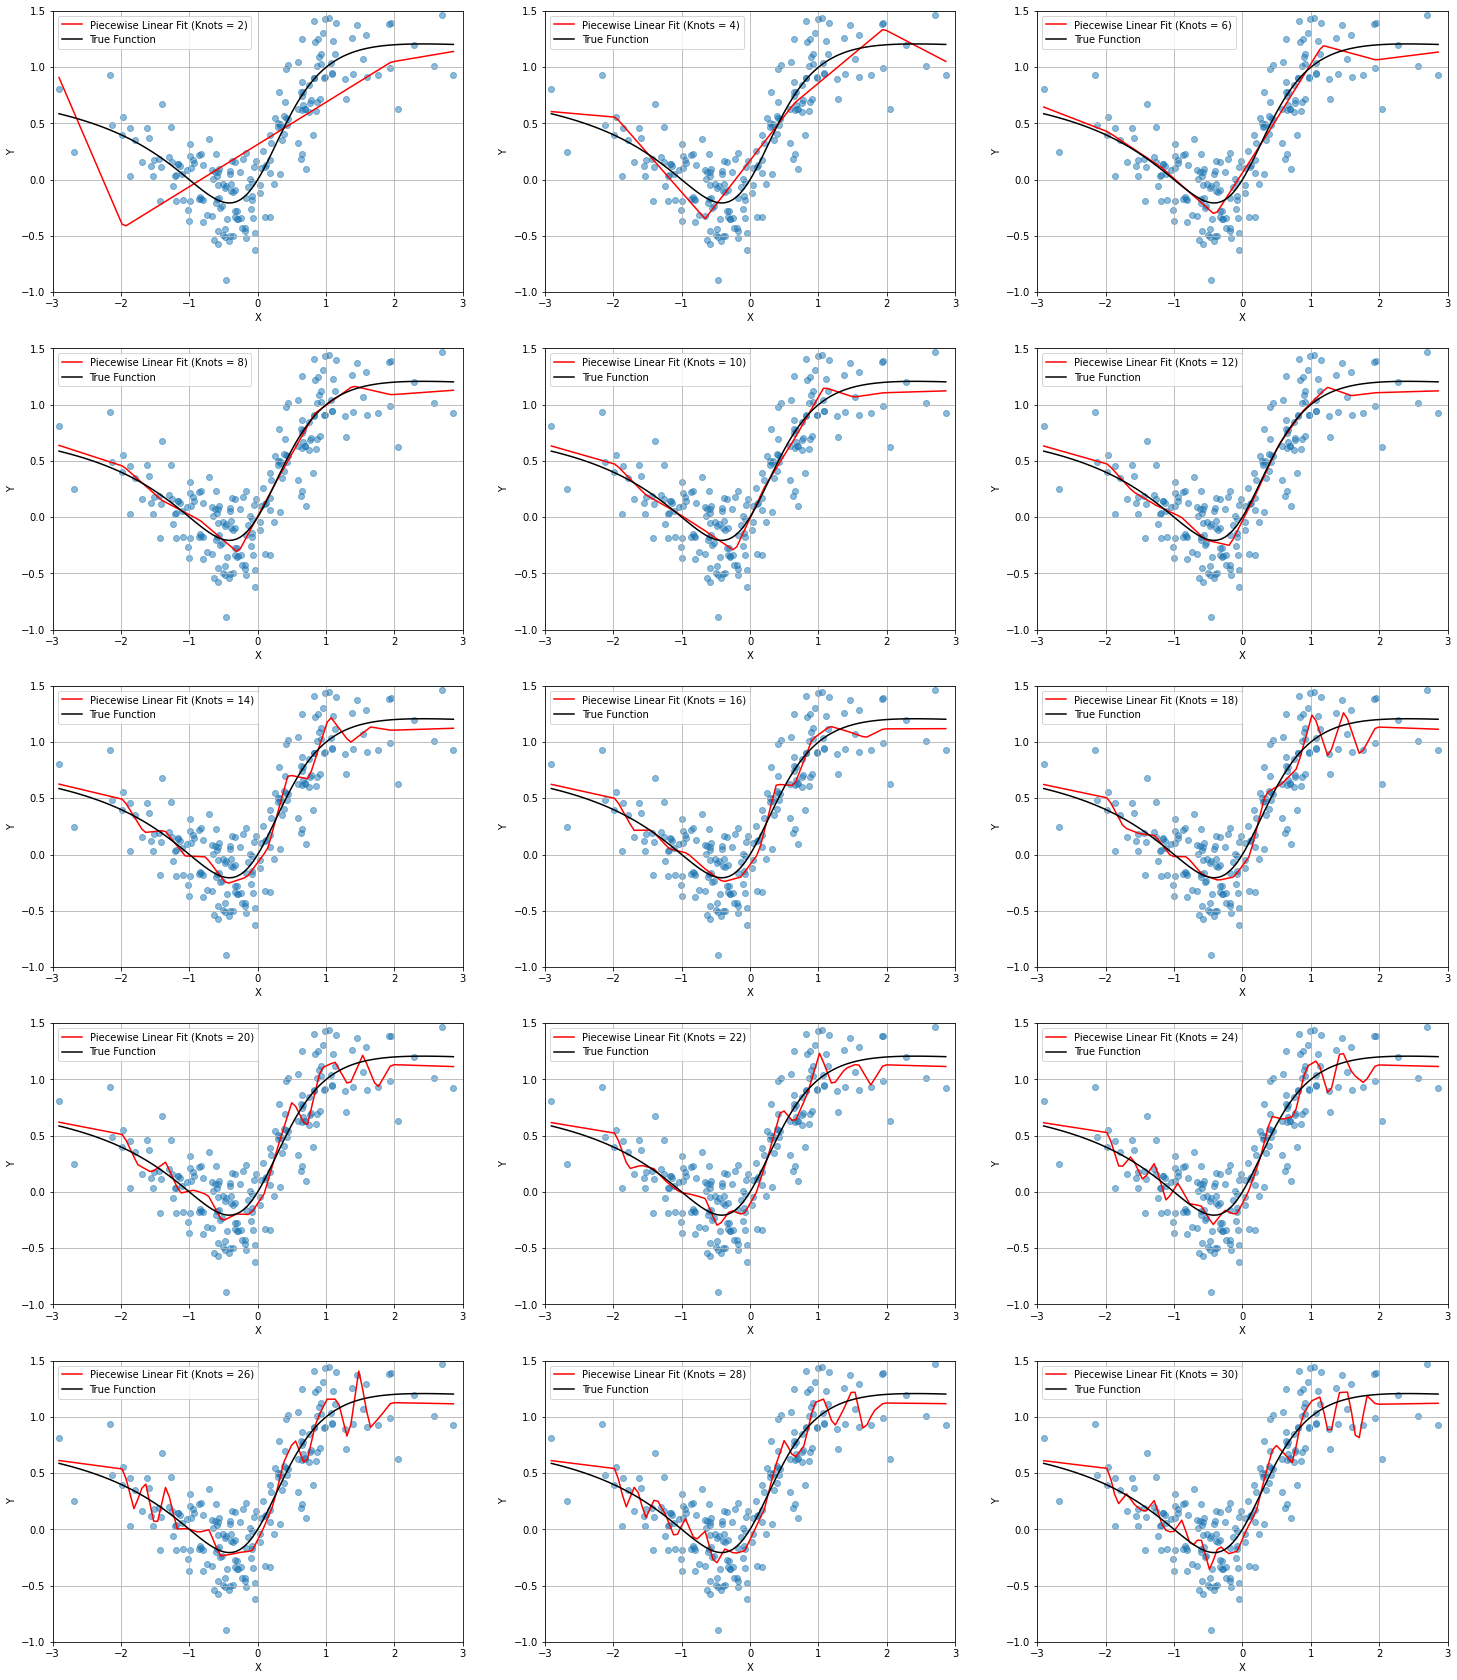

In [5]:
fig, ax = plt.subplots(5,3,figsize=(25,30))
for i in range(15) :
    xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 2*i+2)
    ps, fs = pwlin_fit(X, Y, xknots)
    ax[i//3][i%3].scatter(X, Y, alpha=0.5)
    ax[i//3][i%3].plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit (Knots = '+str(2*i+2)+')')
    ax[i//3][i%3].plot(x, g(x), 'k', label='True Function')
    ax[i//3][i%3].legend(loc=0)
    ax[i//3][i%3].set_xlabel('X')
    ax[i//3][i%3].set_ylabel('Y')

#### Comments :

We observe that there is a good fit from knots 6-8 after which there is evidence of overfitting. Before this there is underfitting. For high number of nots we can see that the model also tries  to fit noise 


---

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)/h$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

For nonparametric regression : 
<ul>
<li>We can try different bandwidth values in the kernel regression
<li>We can try different kernels
</ul>

In [6]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def quartic_kern(x) :
    """Quartic kernel function"""
    y = ((1+x)**2)*((1-x)**2)
    y[x<-1] = 0
    y[x>1]  = 0
    return y

def epanechnikov_kern(x) :
    '''Epanechnikov kernel function'''
    y = (1-(x**2))
    y[x<-1] = 0
    y[x>1]  = 0
    return y

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0) 


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
        
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.column_stack((np.ones_like(xdata), xdata-xx))*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy
    
    return np.vectorize(func)(x)

In [7]:
bandwidths = [(4/(3*len(X)))**0.2*np.std(X)] + [0.075*(i+1) for i in range(14)]

kernel_dict = {'Gaussian Kernel':gauss_kern, "Quartic Kernel" : quartic_kern,"Epanechnikov Kernel" : epanechnikov_kern}
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)

def plot_for_kernel(kernel):
    # NW Kernel Regression
    fig, axs = plt.subplots(15,2,figsize=(13,70))
    for i,bw in enumerate(bandwidths) :
        yknots0 = kern_reg(xknots0, X, Y, bw, kernel_dict[kernel])
        f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
        axs[i][0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw))
        axs[i][0].set_title('NW Kernel Regression')
    # Local Linear Regression
    xknots1 = xknots0
    for i,bw in enumerate(bandwidths) :
        yknots1 = ll_reg(xknots1, X, Y, bw, kernel_dict[kernel])
        f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
        axs[i][1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw))
        axs[i][1].set_title('Local Linear Regression')
        for ax in axs[i]:
            ax.scatter(X, Y, alpha=0.5)
            ax.plot(x, g(x), 'k', label='True Function')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.legend(loc=0)


###### Using Gaussian Kernel

Gaussian Kernel


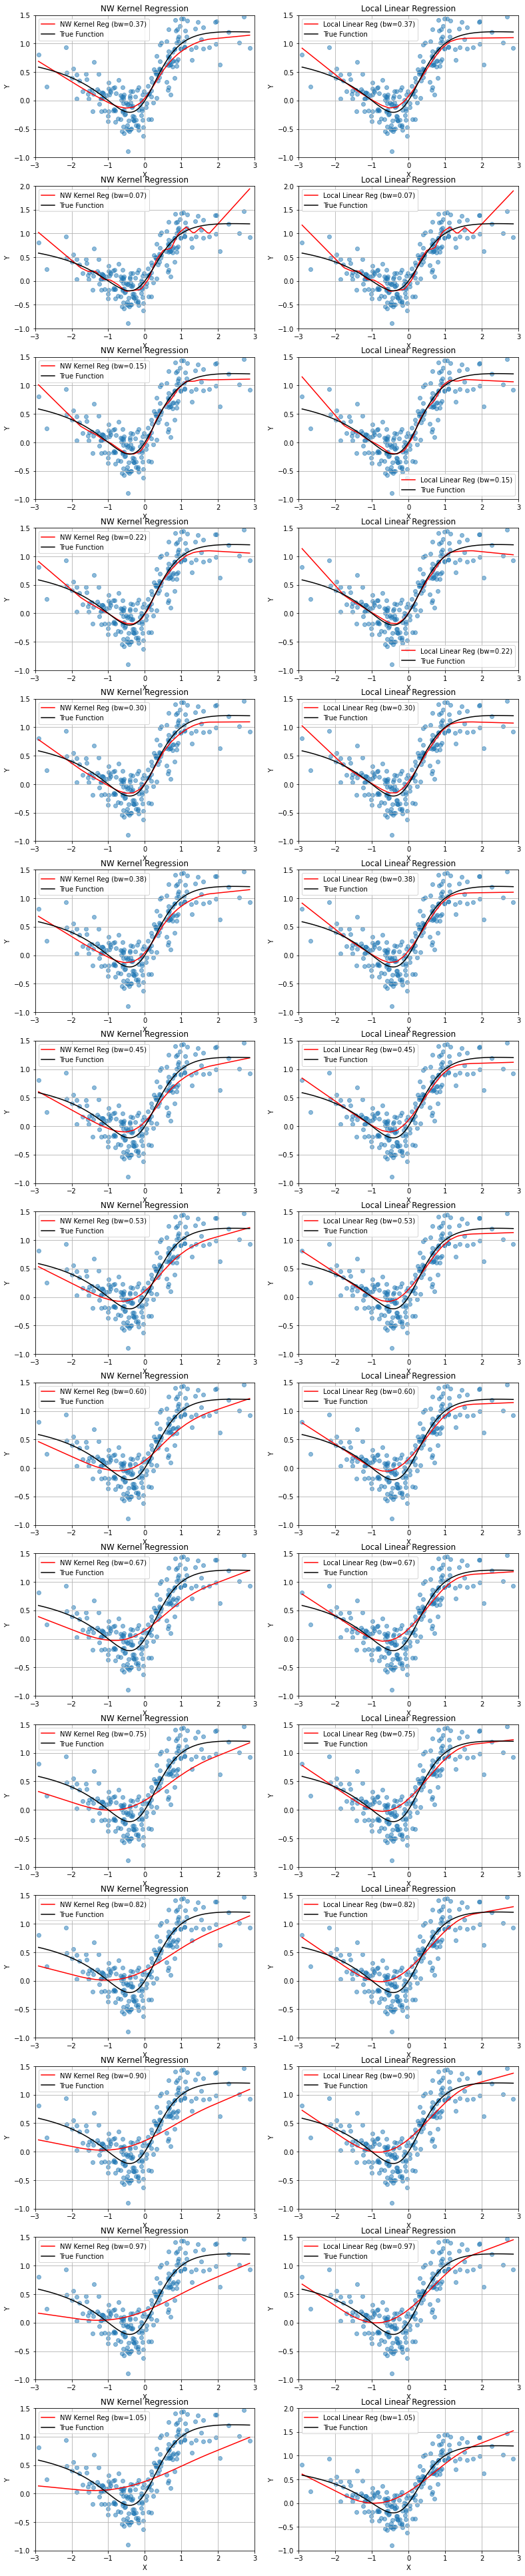

In [8]:
kern = 'Gaussian Kernel'
print(kern)
plot_for_kernel(kern)

###### Comments :
With gaussian kernel we see :
1) For Nadaraya-Watson Kernel regression there is overfitting for bandwidth lower than 0.25. We see that we have a good fit for bandwidth ranging from 0.3-0.45 and above that we observe underfitting

2) For Local Linear Regression we observe very good fit fro 0.38-0.6. Below this range overfitting starts and above this range we see there is underfitting

###### Using Quartic Kernel

Quartic Kernel


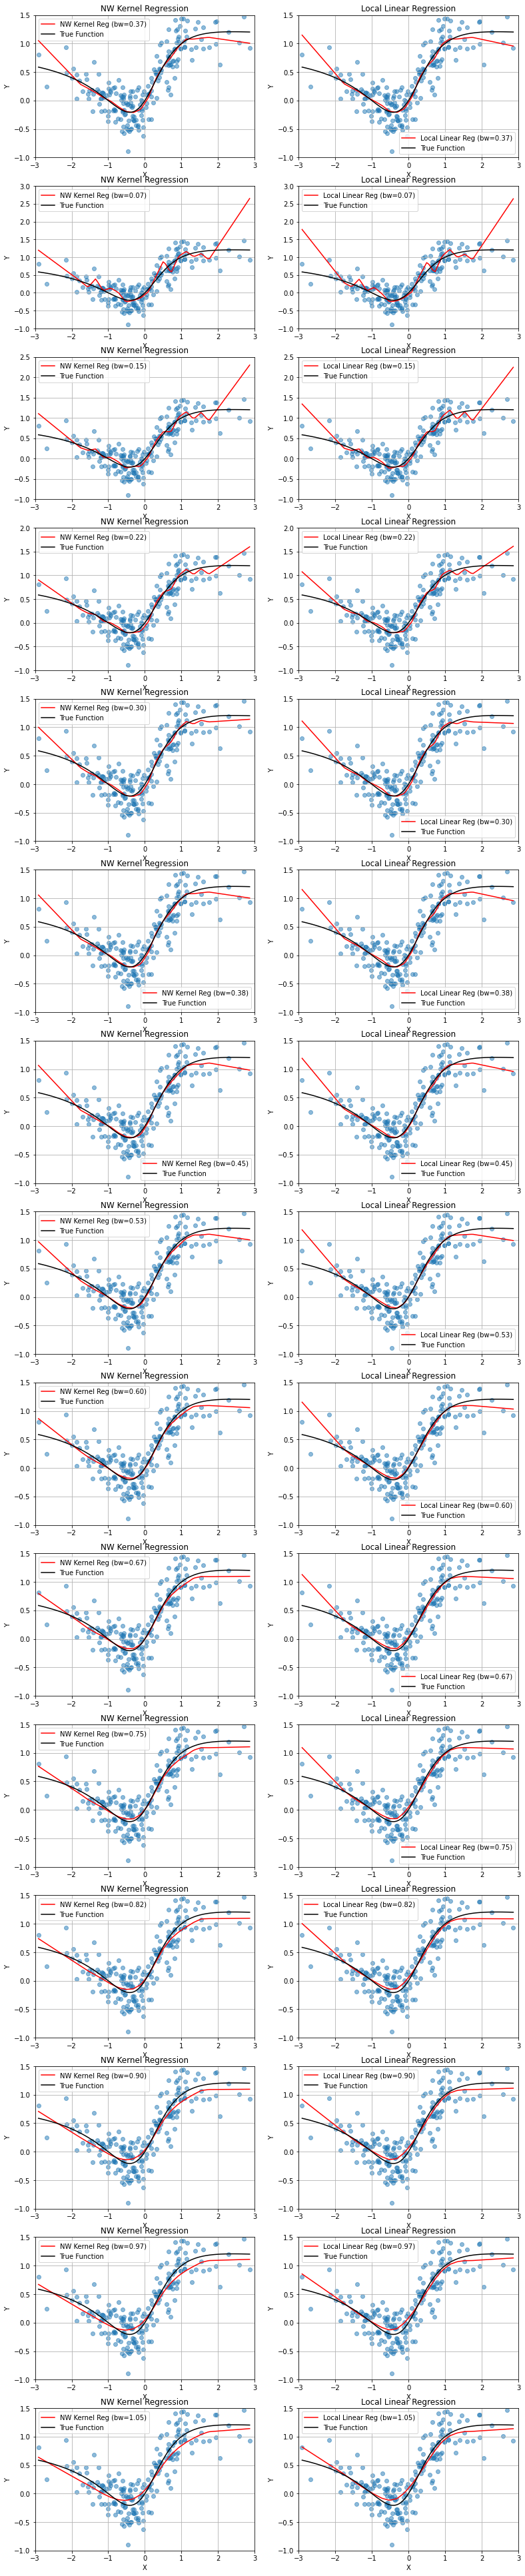

In [9]:
kern = 'Quartic Kernel'
print(kern)
plot_for_kernel(kern)

###### Comments :
With Quartic kernel we see :
1) For Nadaraya-Watson Kernel regression there overfitting starts for bandwidth lower than 0.6. We see that we have a good fit for bandwidth ranging from 0.67-0.82 and above that we start to observe underfitting

2) For Local Linear Regression we observe very good fit for 0.9-1.05. Below this range overfitting starts and above this range  there will be underfitting

Epanechnikov Kernel


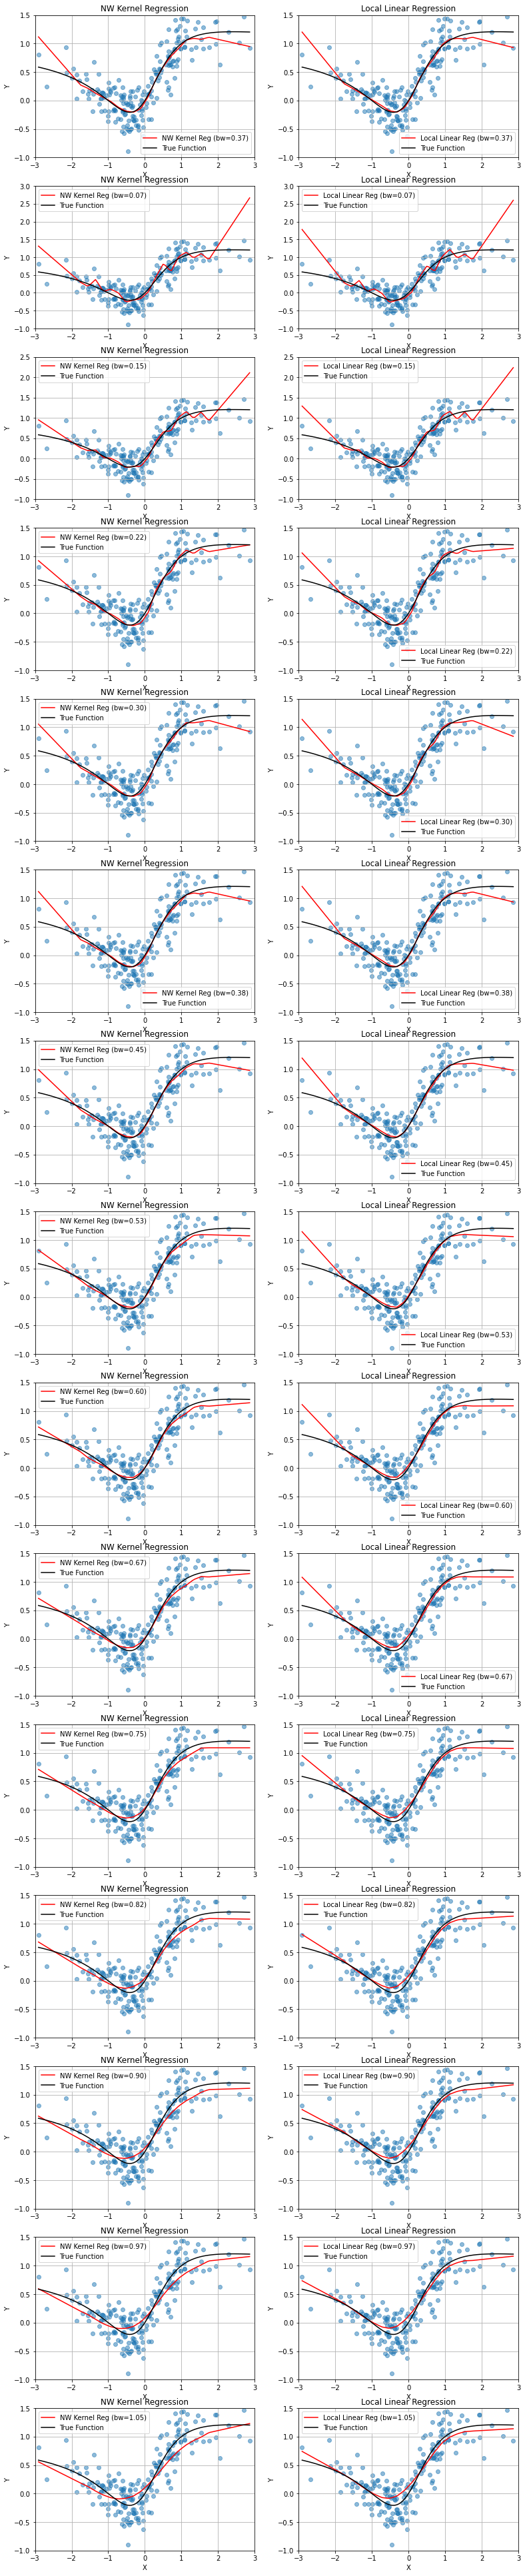

In [10]:
kern = 'Epanechnikov Kernel'
print(kern)
plot_for_kernel(kern)

###### Comments :
With Epanechnikov kernel we see :
1) With this kernel we observe for both regression bandwidth around 0.82-0.9 as very good fit in this case.

---

# American Option Pricing

Path Generation

In [11]:
def blackscholes_mc(ts, n_paths, S0, vol, r, q):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    ts: array_like
        The time steps of the simualtion
    n_paths: int
        the number of paths to simulate
    S0: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    paths = np.full((len(ts), n_paths), np.nan, dtype=np.float64)
    paths[0] = S0
    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        dW = np.sqrt(dt)*np.random.randn(n_paths)
        paths[i+1] = paths[i] * np.exp((r-q-1/2*vol**2)*dt + vol*dW)
    return paths

In [12]:
S0 = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

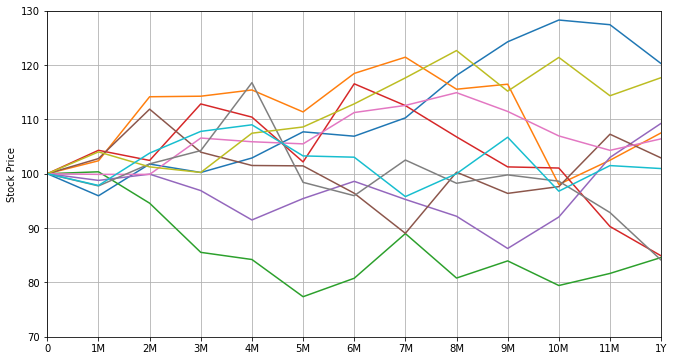

In [13]:
np.random.seed(1000)
ts = np.linspace(0, 1, 13)
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(ts, paths[:, :10])
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)


### Price of European put option

In [14]:
np.mean(np.maximum(K-paths[-1], 0))*np.exp(-r*T)

4.482895510374488

### Price of Bermudan put option with monthly exercises

#### Longstaff-Schwartz algorithm

We use polynomials as basis functions for demonstration purposes.

In [15]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    p = np.polyfit(paths[i], payoff, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

5.069798181424102

#### Tsitsiklis-van Roy algorithm

The price from the TVR algorithm is generally too high because regression errors accumulate in the backward induction.

In [16]:
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    p = np.polyfit(paths[i], V*discount, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
np.mean(V)*np.exp(-r*(ts[1]-ts[0]))

6.427832811750011

Adapting the Longstaff-Schwartz and TVR code to use different regression methods:

<b>(a).</b> Black-Scholes put prices.
<br>
Using the constant 1.0 and the Black-Scholes price of a European put option with volatility $\bar\sigma = 0.2$ and maturity $T-t$ as the two basis functions at time $t$. 

<b>(b).</b> Piecewise Linear regression.

<b>(c).</b> Kernel regression with Gaussian kernel.



In [17]:
def blackscholes_price(K, T, S0, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S0: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S0*np.exp((r-q)*T)
    v = vol*np.sqrt(T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

#### Using Black-Scholes put prices as the basis function :

#### Longstaff-Schwartz algorithm (BS put price as basis function)

In [18]:
S0 = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

In [19]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bs_put = blackscholes_price(K,ts[-1]-ts[i],paths[i],vol,r,q,'put')
    p = np.polyfit(bs_put, payoff, deg=1)
    contval = np.polyval(p, bs_put)
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("Option Price: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

Option Price:  5.281987036317785


#### Tsitsiklis-van Roy algorithm (BS put price as basis function)

In [20]:
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    bs_put = blackscholes_price(K,ts[-1]-ts[i],paths[i],vol,r,q,'put')
    p = np.polyfit(bs_put, V*discount, deg=1)
    contval = np.polyval(p, bs_put)
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
print("Option Price: ",np.mean(V)*np.exp(-r*(ts[1]-ts[0])))

Option Price:  5.356642371146047


#### Using Piecewise Linear Regression

#### Longstaff-Schwartz algorithm (Piecewise Linear Regression)

In [21]:
for knots in range(4,13,2) :
    payoff = np.maximum(K-paths[-1], 0)
    for i in range(len(ts)-2, 0, -1):
        discount = np.exp(-r*(ts[i+1]-ts[i]))
        payoff = payoff*discount
        xknots = np.linspace(np.percentile(paths[i], 2.5), np.percentile(paths[i], 97.5), knots)
        ps, fs = pwlin_fit(paths[i],payoff, xknots)
        contval = sum([f(paths[i])*p for (f, p) in zip(fs, ps)])
        exerval = np.maximum(K-paths[i], 0)
        # identify the paths where we should exercise
        ind = exerval > contval
        payoff[ind] = exerval[ind]
    print("For ", knots," knots: " , " Option Price = ", np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

For  4  knots:   Option Price =  5.227023876906696
For  6  knots:   Option Price =  5.253327901712872
For  8  knots:   Option Price =  5.2876826206825855
For  10  knots:   Option Price =  5.303286076624285
For  12  knots:   Option Price =  5.313317354104395


#### Tsitsiklis-van Roy algorithm (Piecewise Linear Regression)

In [22]:
for knots in range(4,13,2) :
    V = np.maximum(K-paths[-1], 0)
    for i in range(len(ts)-2, 0, -1):
        discount = np.exp(-r*(ts[i+1]-ts[i]))
        xknots = np.linspace(np.percentile(paths[i], 2.5), np.percentile(paths[i], 97.5), knots)
        ps, fs = pwlin_fit(paths[i],V*discount, xknots)
        contval = sum([f(paths[i])*p for (f, p) in zip(fs, ps)])
        exerval = np.maximum(K-paths[i], 0)
        V = np.maximum(exerval, contval)
    print("For ", knots," knots: " , " Option Price = ", np.mean(V)*np.exp(-r*(ts[1]-ts[0])))
    

For  4  knots:   Option Price =  5.3029629469348745
For  6  knots:   Option Price =  5.371123458111384
For  8  knots:   Option Price =  5.289260611070108
For  10  knots:   Option Price =  5.26945282304004
For  12  knots:   Option Price =  5.272616228745614


#### Using Kernel Regression with Gaussian Kernel

#### Longstaff-Schwartz algorithm (Kernel Regression with Gaussian Kernel)

In [23]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bw = (4/(3*len(paths[i])))**0.2*np.std(paths[i])
    xknots0 = np.linspace(np.percentile(paths[i], 2.5), np.percentile(paths[i], 97.5), 20)
    yknots0 = kern_reg(xknots0, paths[i], payoff, bw, gauss_kern)
    contval = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')(paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("Option Price: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

Option Price:  5.284769194215945


#### Tsitsiklis-van Roy algorithm (Kernel Regression with Gaussian Kernel)

In [24]:
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    bw = (4/(3*len(paths[i])))**0.2*np.std(paths[i])
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    xknots0 = np.linspace(np.percentile(paths[i], 2.5), np.percentile(paths[i], 97.5), 20)
    yknots0 = kern_reg(xknots0, paths[i], V*discount, bw, gauss_kern)
    contval = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')(paths[i])
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
print("Option Price: ",np.mean(V)*np.exp(-r*(ts[1]-ts[0])))

Option Price:  5.69492397447138


---

Both TVR and Longstaff-Schwartz algorithms provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue. 

We perform an independent Monte Carlo simulation using this estimate of continuation value from <b>both</b> algorithms as an exercise policy, and estimate the price of the American put. This estimate is a lower bound. The basis functions for regression can be chosen to be the quadratic polynomial as in the sample code.

#### American Option Pricing ( Using both the algorithms)

In [25]:
np.random.seed(1000)
ts = np.linspace(0, 1, 101)
n_paths = 100000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
np.random.seed(500)
independent_paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)

#### American Option Price using Longstaff-Schwartz Algortihm (Quadratic Polynomial)

In [26]:
### Pricing using the same path 

payoff = np.maximum(K-paths[-1], 0)
payoff_indep = np.maximum(K-independent_paths[-1], 0)

for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    payoff_indep = payoff_indep*discount
    
    ## Training model from original paths
    p = np.polyfit(paths[i], payoff, deg=2)
    
    ## Fitting model on both original and independend path
    
    contval = np.polyval(p, paths[i])
    contval_ind = np.polyval(p, independent_paths[i])
    exerval = np.maximum(K-paths[i], 0)
    exerval_ind = np.maximum(K-independent_paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    ind2 = exerval_ind > contval_ind
    
    payoff[ind] = exerval[ind]
    payoff_indep[ind2] = exerval_ind[ind2]
    
print("Price Estimation from the same path: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))
print("Price Estimation from the independent monte carlo path: ",np.mean(payoff_indep*np.exp(-r*(ts[1]-ts[0]))))

Price Estimation from the same path:  4.771202762255353
Price Estimation from the independent monte carlo path:  4.746661152119533


#### American Option Price using Tsitsiklis-van Roy Algorithm (Quadratic Polynomial)

In [27]:
V = np.maximum(K-paths[-1], 0)
V_ind = np.maximum(K-independent_paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    p = np.polyfit(paths[i], V*discount, deg=2)
    
    ## Fiting the model on same and independent path
    contval = np.polyval(p, paths[i])
    contval_ind = np.polyval(p, independent_paths[i])
    exerval = np.maximum(K-paths[i], 0)
    exerval_ind = np.maximum(K-independent_paths[i], 0)
    
    
    V = np.maximum(exerval, contval)
    V_ind = np.maximum(exerval_ind, contval_ind)
print("Price Estimation from the same path: ",np.mean(V)*np.exp(-r*(ts[1]-ts[0])))
print("Price Estimation from the independent monte carlo path: ",np.mean(V_ind)*np.exp(-r*(ts[1]-ts[0])))

Price Estimation from the same path:  7.163535394951902
Price Estimation from the independent monte carlo path:  7.161934774817883


---

Oftentimes parametric regressions may not produce globally accurate estimates of continuation values for all possible values of state variables. One approach to improve the accuracy is to run regression only in the region where option is in the money. When the option is out of money, one should always choose to continue, therefore there is no need to estimate the continuation value.

We modify the Longstaff-Schwartz code to implement this improvement.
For each case, we identify and plot the exercise and continuation regions at time $t=0.5$.

In [28]:
S0 = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

In [29]:
### Paths
np.random.seed(1000)
ts = np.linspace(0, 1, 101)
n_paths = 100000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)

### Independent Paths
np.random.seed(500)
independent_paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)

#### American Option Quadratic Polynommical Basis Function (Longstaff-Schwartz Algorithm - No estimation of OTM options)

In [30]:
## Biased Price by fitting the model on the same path 

payoff = np.maximum(K-paths[-1], 0)
fits   = deque()
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    p = np.polyfit(paths[i][paths[i]<K], payoff[paths[i]<K], deg=2)
    fits.appendleft(p)
    contval = np.polyval(p, paths[i])
    contval[paths[i]>=K] = payoff[paths[i]>=K]
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("Price Estimation from the same path: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

Price Estimation from the same path:  5.182223659151728


In [31]:
## Price by fitting the model on independent path 

payoff = np.maximum(K-independent_paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    p = fits.pop()
    contval = np.polyval(p, independent_paths[i])
    contval[independent_paths[i]>=K] = payoff[independent_paths[i]>=K]
    exerval = np.maximum(K-independent_paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    if i==50 :
        expectedVal = p.copy()
        mid_payoff  = payoff
        mid_spot    = paths[i]
    payoff[ind] = exerval[ind]
    
print("Price Estimation from independent Monte Carlo Path: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

Price Estimation from independent Monte Carlo Path:  5.152302232404452


Plotting the Exercise and Continuation Region

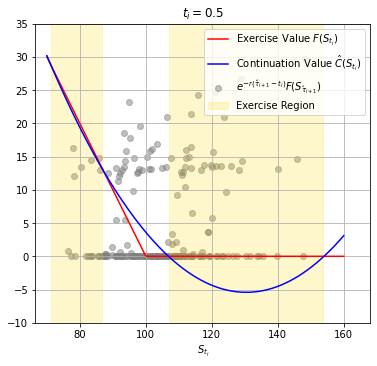

In [32]:
points = np.random.randint(0, 10000, 200)
spot_values    = np.linspace(70,160, 200)
payOff_spot    = np.maximum(K-spot_values, 0)
continuation_spot = np.polyval(expectedVal, spot_values)

fig, ax = plt.subplots()
ax.set_xlim(left=70*0.95, right=160*1.05)
ax.set_ylim(bottom=-10, top=35)
ax.plot(spot_values, payOff_spot, label='Exercise Value $F(S_{t_{i}})$', color='r')
ax.plot(spot_values, continuation_spot, label='Continuation Value $\hat{C}(S_{t_{i}})$', color='b')
ax.scatter(mid_spot[points], mid_payoff[points], label='$e^{-r(\hat{τ}_{i+1}-t_{i})}F(S_{\hat{τ}_{i+1}})$', color='grey', alpha=0.5)
ax.fill_between(spot_values,-10,35,where=(payOff_spot>continuation_spot),color='gold', alpha=0.2, label='Exercise Region')
ax.set_xlabel('$S_{t_{i}}$')
ax.set_title('$t_{i}=0.5$')
ax.legend(loc=0)



#### American Option BS Put price Basis Function (Longstaff-Schwartz Algorithm - No estimation of OTM options) 

In [33]:
## Biased Price by fitting the model on the same path 

payoff = np.maximum(K-paths[-1], 0)
fits   = deque()
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bs_put = blackscholes_price(K,ts[-1]-ts[i],paths[i],vol,r,q,'put')
    p = np.polyfit(bs_put[paths[i]<K], payoff[paths[i]<K], deg=1)
    fits.appendleft(p)
    contval = np.polyval(p, bs_put)
    contval[paths[i]>=K] = payoff[paths[i]>=K]
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("Price Estimation from the same path: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

Price Estimation from the same path:  5.202854013275143


In [34]:
## Price by fitting the model on indpendent path 

payoff = np.maximum(K-independent_paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bs_put = blackscholes_price(K,ts[-1]-ts[i],independent_paths[i],vol,r,q,'put')
    p = fits.pop()
    contval = np.polyval(p, bs_put)
    contval[independent_paths[i]>=K] = payoff[independent_paths[i]>=K]
    exerval = np.maximum(K-independent_paths[i], 0)
    # identify the paths where we should exercise
    if i==50 :
        expectedVal = p.copy()
        mid_payoff  = payoff
        mid_spot    = paths[i]
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("Price Estimation from independent Monte Carlo Path: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

Price Estimation from independent Monte Carlo Path:  5.174700481671713


Plotting the Exercise and Continuation Region

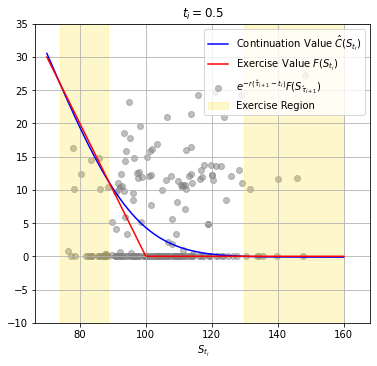

In [35]:
bs_put_spot = blackscholes_price(K,ts[-1]-ts[50],spot_values,vol,r,q,'put')
continuation_spot = np.polyval(expectedVal, bs_put_spot)


fig, ax = plt.subplots()
ax.set_xlim(left=70*0.95, right=160*1.05)
ax.set_ylim(bottom=-10, top=35)
ax.plot(spot_values, continuation_spot, label='Continuation Value $\hat{C}(S_{t_{i}})$', color='b')
ax.plot(spot_values, payOff_spot, label='Exercise Value $F(S_{t_{i}})$', color='r')
ax.scatter(mid_spot[points], mid_payoff[points], label='$e^{-r(\hat{τ}_{i+1}-t_{i})}F(S_{\hat{τ}_{i+1}})$', color='grey', alpha=0.5)
ax.fill_between(spot_values,-10,35,where=(payOff_spot>continuation_spot),color='gold', alpha=0.2, label='Exercise Region')
ax.set_xlabel('$S_{t_{i}}$')
ax.set_title('$t_{i}=0.5$')
ax.legend(loc=0)



---

Now we use the Longstaff-Schwartz algorithm to price an Bermudan-Asian call option. The underlying security price is assumed to follow the geometric Brownian motion

$$\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$$

with $S_0=100$, $r=0$, $q=0$ and $\sigma=0.2$. The option has a strike of $K=100$ and a final expiration date of $T=1$ and can be exercised every month before the final maturity, i.e.
$$t_1=\frac{1}{12},\, t_2=\frac{2}{12},\, \ldots,\, t_{12}=1$$

The cashflow from exercising the option at time $t_n$, $n=1,\ldots,12$, is $\max\left(0, A_{t_n}-K\right)$ with $A_{t_n}=\frac{1}{n}\sum_{i=1}^nS_{t_i}$.

<b>(a)</b> As the basis functions in the regression at time $t_n$, use the constant 1.0 and the Black-Scholes value of a European call option with strike $K$, maturity $T-t_n$, volatility $\bar\sigma = 0.1$, and the spot value
$$
Z_{t_n}\equiv \frac{nA_{t_n}+(12-n)S_{t_n}}{12}
$$

As in previous case after we obtain estimations of continuation values from the Longstaff-Schwartz algorithm, we run an independent Monte Carlo simulation to obtain a low-biased price. 

<b>(b)</b> We also implement a feed-forward neural network to estimate the conditional value at each time step. The network should take both $S_{t_n}$ and $A_{t_n}$ as inputs. 

For this problem, we use the following hyperparameters: 3 hidden layers with 20 neurons and RELU activation on each layer. To control the time of training, we recommend training size of 50000 paths and batch size of 128 in the stochastic gradient descent. 

In [36]:
S0 = 100
vol = 0.2
r = 0
q = 0
K = 100
T = 1

######  Bermudan Asian Option with BS Price as basis function (Longstaff-Schwartz algorithm)

In [37]:
### Generating Paths
np.random.seed(1000)
ts = np.linspace(0, 1, 13)
n_paths = 100000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
A_paths = np.copy(paths)
Z_paths = np.copy(paths)

for i in range(2,len(A_paths)) :
    A_paths[i] += A_paths[i-1]
    
for i in range(1,len(paths)) :
    A_paths[i]  = A_paths[i]/i
    Z_paths[i]  = (i*A_paths[i]+(12-i)*paths[i])/12
    
### Generating independent Paths 

np.random.seed(500)
independent_paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
A_IndPaths = independent_paths.copy()
Z_IndPaths = np.copy(paths)

for i in range(2,len(A_paths)) :
    A_IndPaths[i] +=  A_IndPaths[i-1]

for i in range(1,len(A_paths)) :
    A_IndPaths[i] = A_IndPaths[i]/i    
    Z_IndPaths[i] = (i*A_IndPaths[i] + (12-i)*independent_paths[i])/12
    

In [38]:
## Biased Price by fitting the model on the same path 

payoff = np.maximum(A_paths[-1]-K, 0)
fits   = deque()

for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bs_put = blackscholes_price(K,ts[-1]-ts[i],Z_paths[i],vol=0.1,r=0,q=0,callput='call')
    p = np.polyfit(bs_put[A_paths[i]>K], payoff[A_paths[i]>K], deg=1)
    fits.appendleft(p)
    contval = np.polyval(p, bs_put)
    contval[A_paths[i]<=K] = payoff[A_paths[i]<=K]
    exerval = np.maximum(A_paths[i]-K, 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("Price Estimation from the same path: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

Price Estimation from the same path:  5.2994440726579


In [39]:
## Price by fitting model on independent path 

payoff = np.maximum(A_IndPaths[-1]-K, 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    bs_put = blackscholes_price(K,ts[-1]-ts[i],Z_IndPaths[i],vol=0.1,r=0,q=0,callput='call')
    p = fits.pop()
    contval = np.polyval(p, bs_put)
    contval[A_IndPaths[i]<=K] = payoff[A_IndPaths[i]<=K]
    exerval = np.maximum(A_IndPaths[i]-K, 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print("Price Estimation from independent Monte Carlo path: ",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))


Price Estimation from independent Monte Carlo path:  5.358902317139679


If we simply use $S_{t_n}$ we are ingnoring historical information and it will not be suitable for Asian options since there payoff is dependent on past prices. Using just $A_{t_n}$ will also not be suitable as it assumes equal weight for all the past prices and could lead to bad fitting. As inputs we want to provide some weight to current prices as well along with including information for past prices. As timesteps increase $Z_{t_n}$ coverges to  $A_{t_n}$. This could lead to lower variance as compared to other inputs while fitting.


#### Using Neural Network to estimate conditional value at each time step

In [40]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.7.0


In [41]:
def build_NN(X,Y):
    
    model = keras.Sequential([
      keras.layers.Dense(20, activation='relu', input_shape=[2]),
      keras.layers.Dense(20, activation='relu'),
      keras.layers.Dense(20, activation='relu'),
      keras.layers.Dense(1)
    ])
    
    
    # We use MAE as the loss function and Adam algorithm as the optimizer
    model.compile(loss=keras.losses.MeanSquaredError(), 
                   optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name='SGD'))

    
    history = model.fit(X, Y,batch_size=128,validation_split=0.2,verbose=0,epochs=100)
    
#     print(pd.DataFrame(history.history))
    
    return model

In [42]:
np.random.seed(1000)
ts = np.linspace(0, 1, 13)
n_paths = 100000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
A_paths = paths.copy()
Z_paths = np.copy(paths)

for i in range(2,len(A_paths)) :
    A_paths[i] += A_paths[i-1]
    
for i in range(1,len(paths)) :
    A_paths[i]  = A_paths[i]/i
    Z_paths[i]  = (i*A_paths[i]+(12-i)*paths[i])/12
    

In [43]:
### Generating independent Paths 
np.random.seed(500)
independent_paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)  ### Simulating 1000000 independent paths for low-bias price
A_IndPaths = independent_paths.copy()
Z_IndPaths = np.copy(independent_paths)

for i in range(2,len(A_paths)) :
    A_IndPaths[i] +=  A_IndPaths[i-1]

for i in range(1,len(A_paths)) :
    A_IndPaths[i] = A_IndPaths[i]/i
    Z_IndPaths[i] = (i*A_IndPaths[i] + (12-i)*independent_paths[i])/12
    

In [44]:
payoff = np.maximum(A_paths[-1]-K, 0)
payoff_ind = np.maximum(A_IndPaths[-1]-K, 0)

for i in range(len(ts)-2, 0, -1):
    print('Time Period Iteration: ',i)
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff   = payoff*discount
    payoff_ind = payoff_ind*discount 
    tf.keras.backend.clear_session()
    
    ## Normalizing Vectors for training 
    f1 = paths[i][A_paths[i]>K]
    f2 = A_paths[i][A_paths[i]>K]
    normalized_f1 = (f1-np.mean(f1))/np.std(f1)
    normalized_f2 = (f2-np.mean(f2))/np.std(f2)
    
    ## Normalizing Vectors for estimation
    f1_ind = independent_paths[i]
    f2_ind = A_IndPaths[i]
    normalized_f1_ind = (f1_ind-np.mean(f1_ind))/np.std(f1_ind)
    normalized_f2_ind = (f2_ind-np.mean(f2_ind))/np.std(f2_ind)
    
    ## Stacking training and estimation features
    
    train_features = np.vstack((normalized_f1,normalized_f2)).T
    fit_features = np.vstack((normalized_f1_ind,normalized_f2_ind)).T
    
    ### Training the model
    p        = build_NN(train_features, payoff[A_paths[i]>K]) 
    
    ## Estimation from the model
    contval = p.predict(np.asarray(fit_features)).flatten()
    
    ### Removing estimation for OTM/ATM options
    contval[A_IndPaths[i]<=K] = payoff_ind[A_IndPaths[i]<=K]
    
    exerval = np.maximum(A_IndPaths[i]-K, 0)
    # identify the paths where we should exercise
    ind = exerval > contval
#     payoff_ind[ind] = exerval[ind]
    
print("Option Price :",np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

Time Period Iteration:  11
Time Period Iteration:  10
Time Period Iteration:  9
Time Period Iteration:  8
Time Period Iteration:  7
Time Period Iteration:  6
Time Period Iteration:  5
Time Period Iteration:  4
Time Period Iteration:  3
Time Period Iteration:  2
Time Period Iteration:  1
Option Price : 4.857046480363535
